# Exercise 2
(a) Consider the anisotropic diffusion equation:

$$
-\left(\mu_x\frac{\partial^2 u}{\partial x^2} + \mu_y\frac{\partial^2 u}{\partial y^2}\right) = f(x,y)
$$

for

$$
(x,y) \in (0,1) \times (0,1)
$$

and $u = 0$ on $\Gamma$

The discretisation yields:

$$
-\mu_x \left(\frac{u_{i-1,j} - 2u_{i,j} + u_{i+1,j}}{h^2}\right)-\mu_y \left(\frac{u_{i,j-1} - 2u_{i,j} + u_{i,j+1}}{h^2}\right) = f_{i,j}
$$

The second order stencil is given by:

$$
S = 
\begin{bmatrix}
s_{11} & s_{12} & s_{13}\\
s_{21} & s_{22} & s_{23}\\
s_{31} & s_{32} & s_{33}\\
\end{bmatrix}
=
\begin{bmatrix}
0 & -\mu_y & 0\\
-\mu_x & 2(\mu_x + \mu_y) & -\mu_x\\
0 & -\mu_y & 0\\
\end{bmatrix}
$$

(b) We define a source function source_function( x, y, h )


In [1]:
import numpy as np
def source_function( x, y ):
    if ( x >= 0.1 and x <= 0.3 and y >= 0.1 and y <= 0.3 ):
        return 1.0
    else:
        return 0.0

np_source_function = np.vectorize(source_function)

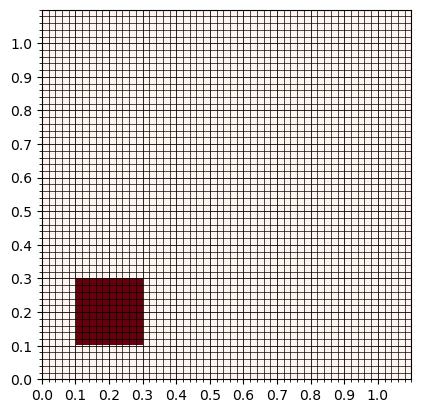

In [2]:
import matplotlib.pyplot as plt
import numpy as np
h=0.1
# Generate a grid of x and y values
x_values = np.arange(0., 1.+h, h)
y_values = np.arange(0., 1.+h, h)

# Create a matrix to store the z values
z_values = np.zeros((len(y_values), len(x_values)))

# Calculate the z values using the source function
for i, x in enumerate(x_values):
    for j, y in enumerate(y_values):
        z_values[j, i] = source_function(x, y)

# Create the heatmap
plt.imshow(z_values, cmap='Reds', interpolation='nearest', extent=[0, 1.+h, 0, 1.+h], origin='lower')

# Add a grid
plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.6)
plt.minorticks_on()
plt.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.5)
major_ticks = np.arange(0., 1.+h, h)
minor_ticks = np.arange(0., 1.+h, h/5)

plt.xticks(major_ticks)
plt.yticks(major_ticks)

# Show the plot
plt.show()



In [3]:
import scipy as sp
import numpy as np
from scipy.sparse.linalg import norm

def myNewtonSys(fnon, jac, x0, tol, maxk, *fnonargs):
    # fnon     - name of the nonlinear function f(x)
    # jac      - name of the Jacobian function J(x)
    # x0       - initial guess for the solution x0
    # tol      - stopping tolerance for Newton's iteration
    # maxk     - maximum number of Newton iterations before stopping
    # fnonargs - optional arguments that will be passed to the nonlinear function (useful for additional function parameters)

    k = 0
    x = x0

    F = eval(fnon)(x,*fnonargs)
    Fsize = F.get_shape()
    n = Fsize[0]

    normF = (F.data ** 2).sum()

    print(' k    f(xk)')

    # Main Newton loop
    while (normF > tol and k <= maxk):
        # Evaluate Jacobian matrix
        J = eval(jac)(x,n,fnon,F,*fnonargs)

        # Take Newton step by solving the tangent problem
        # (we will use the dense linear solver from NumPy for now...)
        delta = np.linalg.solve(J.toarray(),F.toarray())
        x = x - delta

        F = eval(fnon)(x,*fnonargs)
        normF = (F.data ** 2).sum()

        print('{0:2.0f}  {1:2.2e}'.format(k, normF))
        k += 1

    if (k >= maxk):
        print('Not converged')
    else:
        return x

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(c) Create the matrix for the diffusion equation

In [4]:
# Finds the index k = 0,1,2,...,N-1 in the vector corresponding to the grid
# point (x_i, y_j) where i,j = 0,1,2,...,n-1

def indexFD(i, j, n):
  k = ( i*n + j )
  return k

def reverseIndexFD(k, n):
    i = k // n
    j = k % n
    return i, j

In [5]:
import scipy as sp
import numpy as np

def diffusionMatrix( mux, muy, n ):

  N = n**2

  A = sp.sparse.lil_array((N, N), dtype=np.float64)
  h = 1. / (n-1);

  # Pass through all grid points and apply local stencil

  stencil = np.array([(mux+muy)*2., -mux*1., -mux*1., -muy*1., -muy*1.]) / h**2

  # Loop over each internal node in the grid, i,j = 1,2,...,n-2
  for i in range(1,n-1):
    for j in range(1,n-1):
      # Find k-indices of the four neighbouring nodes
      localStencilIndices = np.array([indexFD(i,j,n), indexFD(i+1,j,n), indexFD(i-1,j,n), indexFD(i,j+1,n), indexFD(i,j-1,n)])

      # Add the local stencil for node (x_i,y_j) to the matrix
      currentRow = indexFD(i,j,n)
      for m in range (0,5):
        A[currentRow, localStencilIndices[m]] = A[currentRow, localStencilIndices[m]] + stencil[m]

  # After the matrix A has been assembled, we convert it to the column-major format
  # for more efficient computations
  A = A.tocsc()

  return (A)

In [6]:
import numpy as np

def boundaryConditions(n):

  extNodes = []

  # Find nodes at the boundary of the square
  for j in range(0,n):
    extNodes.append( indexFD(j,0,n) )
    extNodes.append( indexFD(j,n-1,n) )
    extNodes.append( indexFD(0,j,n) )
    extNodes.append( indexFD(n-1,j,n) )

  extNodes = np.unique(extNodes)
  intNodes = np.setdiff1d(np.arange(0,n**2), extNodes);

  return intNodes, extNodes

In [7]:
import scipy as sp
import copy

def fdJacobian(x,n,fnon,F0,*fnonargs):
  # We replace the dense NumPy array with a sparse SciPy matrix
  # (list-of-lists format is used for assembly)

  J = sp.sparse.lil_array((n, n), dtype=np.float64)
  h = 10e-8

  for k in range(0,n):
    xb = copy.deepcopy(x)
    xb[k,0] = xb[k,0] + h

    F = eval(fnon)(xb,*fnonargs)

    for i in range(0,n):
      J[i,k] = (F[i,0] - F0[i,0]) / h

  # Return the Jacobian in column-major sparse format
  return J.tocsc()

In [8]:
import math

def diffusionF( u, A, n ):

  N = n**2
  f = sp.sparse.lil_array((N, 1), dtype=np.float64)
  h = 1. / (n-1)

  
  # Find the internal nodes and the boundary nodes
  intNodes, extNodes  = boundaryConditions(n)

  # Evaluate the nonlinear Laplacian equation (make sure to use sparse matrix-vector multiplication)

  Au = A[intNodes,:] @ u # Sparse matrix-vector multiplication
  F = sp.sparse.lil_array((N, 1), dtype=np.float64)

  # Evaluate the nonlinear function F(u) = (u - 1)^2
  for k in intNodes:
    i, j = reverseIndexFD(k, n)
    F[k] = source_function( i*h, j*h )

  f[intNodes] = Au - F[intNodes]

  # Set value of U at boundary nodes (this imposes u=0 at the boundary)
  f[extNodes] = u[extNodes]

  return f.tocsc()

Main PDE solver

In [9]:
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import time

def diffusionSolver(mux, muy, h):

  n = int(1./h + 1)  # dimension of spatial mesh in each dimension
  N = n**2      # total number of grid points

  # Initial guess for Newton is the zero vector
  u0 = sp.sparse.csc_array( (N,1), dtype=np.float64 )

  # Assemble the Laplacian matrix
  A = diffusionMatrix(mux, muy, n)

  # We plot the sparsity pattern of the matrix A to check that it has been
  # correctly assembled.
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(A.toarray(), vmin=-4./h*mux, vmax=4./h*mux, cmap='coolwarm')
  plt.title("Sparsity pattern")
  fig.colorbar(cax)
  plt.show()

  # Newton iteration to solve nonlinear PDE
  u = myNewtonSys( "diffusionF", "fdJacobian", u0, 1e-6, 100, A, n )

  return u

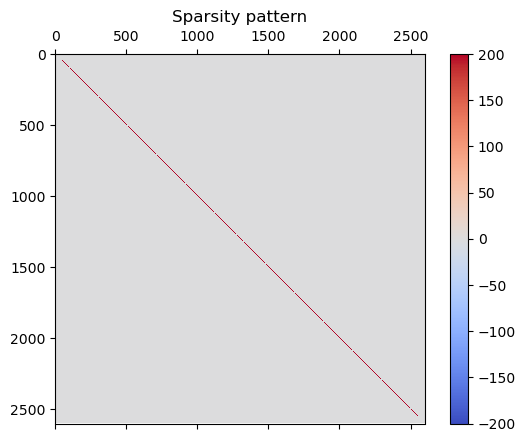

 k    f(xk)
 0  8.97e-20


In [52]:
h = 0.02
mux = 1
muy = 1
sol = diffusionSolver(mux, muy, h)

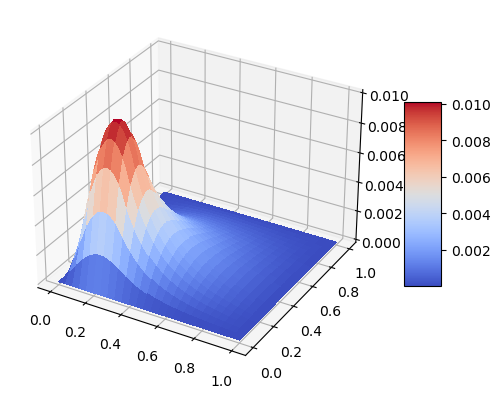

In [53]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0., 1.+h, h)
Y = np.arange(0., 1.+h, h)
X, Y = np.meshgrid(X, Y)
Z = sol.reshape(int(1./h+1),int(1./h+1))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0.0, 0.01)


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

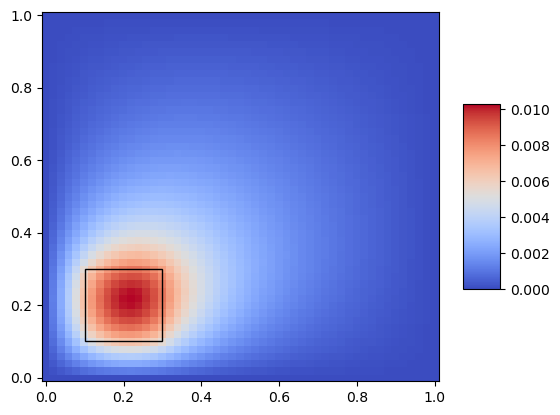

In [54]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.patches as patches

fig, ax = plt.subplots()

# Make data.
X = np.arange(0., 1.+h, h)
Y = np.arange(0., 1.+h, h)
X, Y = np.meshgrid(X, Y)
Z = sol.reshape(int(1./h+1),int(1./h+1))

# Plot the surface.
surf = ax.pcolor(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Create a Rectangle patch
rect = patches.Rectangle((0.1, 0.1), 0.2, 0.2, linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()